In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 50
CSV_FILE_PATH = '../gyroscope_data_updated.csv'

def alineData(df):
    def alineDateWithLabel(label, df):
        lable_data = df[df['activity_type'] == label]
        return lable_data[0:lable_data.shape[0] - lable_data.shape[0] % MEASUREMENTS_PER_SAMPLE]
    
    return pd.concat([alineDateWithLabel(label, df) for label in df['activity_type'].unique()])

df = alineData(pd.read_csv(CSV_FILE_PATH))
samples_number = df.shape[0] // MEASUREMENTS_PER_SAMPLE

def prepareTargets(df):
    df = df[df.columns[-1:len(df.columns)]]
    
    def prepareTarget(sample_index):
        sample_start_index = sample_index * MEASUREMENTS_PER_SAMPLE
        sample_end_index = (sample_index + 1) * MEASUREMENTS_PER_SAMPLE
        
        targets = df[sample_start_index:sample_end_index]['activity_type'].unique()
        
        if(targets.size > 1):
            raise ValueError('Sample can not have more then one target')
        
        return targets[0] 
    
    return LabelBinarizer().fit_transform(np.array([prepareTarget(index) for index in range(0, samples_number)]))

def prepareSamples(df):
    return df[df.columns[0:-1]].values.reshape((samples_number, MEASUREMENTS_PER_SAMPLE, 6))

samples = prepareSamples(df)
targets = prepareTargets(df)

print(samples.shape)
print(targets.shape)

(1532, 50, 6)
(1532, 5)


In [3]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [4]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(919, 50, 6)
(919, 5)
(306, 50, 6)
(306, 5)
(306, 50, 6)
(306, 5)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.55))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(test_labels.shape[-1], activation='softmax'))

In [6]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [7]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

history = model.fit(train_data,
                    train_labels,
                    epochs=1000,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 919 samples, validate on 306 samples
Epoch 1/1000
919/919 [==============================] - 0s 336us/step - loss: 0.2590 - acc: 0.3036 - val_loss: 0.2063 - val_acc: 0.3725
Epoch 2/1000
919/919 [==============================] - 0s 76us/step - loss: 0.2460 - acc: 0.3428 - val_loss: 0.1760 - val_acc: 0.4935
Epoch 3/1000
919/919 [==============================] - 0s 81us/step - loss: 0.2408 - acc: 0.3591 - val_loss: 0.1939 - val_acc: 0.4608
Epoch 4/1000
919/919 [==============================] - 0s 80us/step - loss: 0.2331 - acc: 0.3732 - val_loss: 0.1622 - val_acc: 0.5458
Epoch 5/1000
919/919 [==============================] - 0s 78us/step - loss: 0.2304 - acc: 0.3830 - val_loss: 0.1576 - val_acc: 0.5556
Epoch 6/1000
919/919 [==============================] - 0s 89us/step - loss: 0.2275 - acc: 0.3972 - val_loss: 0.1541 - val_acc: 0.5817
Epoch 7/1000
919/919 [==============================] - 0s 77us/step - loss: 0.2156 - acc: 0.4287 - val_loss: 0.1496 - val_acc: 0.5882
Epoch 8/

Epoch 61/1000
919/919 [==============================] - 0s 73us/step - loss: 0.1063 - acc: 0.6387 - val_loss: 0.1035 - val_acc: 0.6503
Epoch 62/1000
919/919 [==============================] - 0s 81us/step - loss: 0.1059 - acc: 0.6376 - val_loss: 0.1041 - val_acc: 0.6503
Epoch 63/1000
919/919 [==============================] - 0s 77us/step - loss: 0.1082 - acc: 0.6387 - val_loss: 0.1001 - val_acc: 0.6699
Epoch 64/1000
919/919 [==============================] - 0s 72us/step - loss: 0.1032 - acc: 0.6605 - val_loss: 0.0996 - val_acc: 0.6569
Epoch 65/1000
919/919 [==============================] - 0s 71us/step - loss: 0.1068 - acc: 0.6268 - val_loss: 0.0979 - val_acc: 0.6765
Epoch 66/1000
919/919 [==============================] - 0s 70us/step - loss: 0.1052 - acc: 0.6431 - val_loss: 0.0958 - val_acc: 0.6797
Epoch 67/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0989 - acc: 0.6736 - val_loss: 0.0952 - val_acc: 0.6961
Epoch 68/1000
919/919 [=========================

919/919 [==============================] - 0s 69us/step - loss: 0.0692 - acc: 0.7606 - val_loss: 0.0671 - val_acc: 0.7745
Epoch 122/1000
919/919 [==============================] - 0s 79us/step - loss: 0.0721 - acc: 0.7421 - val_loss: 0.0652 - val_acc: 0.7974
Epoch 123/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0674 - acc: 0.7726 - val_loss: 0.0664 - val_acc: 0.7745
Epoch 124/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0664 - acc: 0.7813 - val_loss: 0.0668 - val_acc: 0.7745
Epoch 125/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0673 - acc: 0.7791 - val_loss: 0.0681 - val_acc: 0.7680
Epoch 126/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0703 - acc: 0.7628 - val_loss: 0.0670 - val_acc: 0.7712
Epoch 127/1000
919/919 [==============================] - 0s 73us/step - loss: 0.0628 - acc: 0.7965 - val_loss: 0.0656 - val_acc: 0.7745
Epoch 128/1000
919/919 [==============================] 

Epoch 181/1000
919/919 [==============================] - 0s 72us/step - loss: 0.0493 - acc: 0.8422 - val_loss: 0.0556 - val_acc: 0.8235
Epoch 182/1000
919/919 [==============================] - 0s 69us/step - loss: 0.0533 - acc: 0.8270 - val_loss: 0.0600 - val_acc: 0.8203
Epoch 183/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0515 - acc: 0.8346 - val_loss: 0.0554 - val_acc: 0.8235
Epoch 184/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0503 - acc: 0.8357 - val_loss: 0.0542 - val_acc: 0.8235
Epoch 185/1000
919/919 [==============================] - 0s 72us/step - loss: 0.0527 - acc: 0.8281 - val_loss: 0.0571 - val_acc: 0.8203
Epoch 186/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0534 - acc: 0.8259 - val_loss: 0.0565 - val_acc: 0.8203
Epoch 187/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0526 - acc: 0.8270 - val_loss: 0.0577 - val_acc: 0.8268
Epoch 188/1000
919/919 [=================

Epoch 241/1000
919/919 [==============================] - 0s 70us/step - loss: 0.0404 - acc: 0.8640 - val_loss: 0.0469 - val_acc: 0.8497
Epoch 242/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0399 - acc: 0.8803 - val_loss: 0.0440 - val_acc: 0.8562
Epoch 243/1000
919/919 [==============================] - 0s 70us/step - loss: 0.0394 - acc: 0.8738 - val_loss: 0.0449 - val_acc: 0.8595
Epoch 244/1000
919/919 [==============================] - 0s 73us/step - loss: 0.0407 - acc: 0.8749 - val_loss: 0.0453 - val_acc: 0.8529
Epoch 245/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0444 - acc: 0.8455 - val_loss: 0.0480 - val_acc: 0.8431
Epoch 246/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0382 - acc: 0.8792 - val_loss: 0.0474 - val_acc: 0.8529
Epoch 247/1000
919/919 [==============================] - 0s 76us/step - loss: 0.0395 - acc: 0.8716 - val_loss: 0.0477 - val_acc: 0.8431
Epoch 248/1000
919/919 [=================

Epoch 301/1000
919/919 [==============================] - 0s 77us/step - loss: 0.0315 - acc: 0.9053 - val_loss: 0.0455 - val_acc: 0.8562
Epoch 302/1000
919/919 [==============================] - 0s 72us/step - loss: 0.0383 - acc: 0.8803 - val_loss: 0.0424 - val_acc: 0.8660
Epoch 303/1000
919/919 [==============================] - 0s 78us/step - loss: 0.0333 - acc: 0.9010 - val_loss: 0.0406 - val_acc: 0.8627
Epoch 304/1000
919/919 [==============================] - 0s 75us/step - loss: 0.0353 - acc: 0.8836 - val_loss: 0.0455 - val_acc: 0.8660
Epoch 305/1000
919/919 [==============================] - 0s 78us/step - loss: 0.0313 - acc: 0.8966 - val_loss: 0.0458 - val_acc: 0.8562
Epoch 306/1000
919/919 [==============================] - 0s 77us/step - loss: 0.0355 - acc: 0.8825 - val_loss: 0.0481 - val_acc: 0.8399
Epoch 307/1000
919/919 [==============================] - 0s 77us/step - loss: 0.0309 - acc: 0.9042 - val_loss: 0.0467 - val_acc: 0.8529
Epoch 308/1000
919/919 [=================

Epoch 361/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0313 - acc: 0.9042 - val_loss: 0.0434 - val_acc: 0.8595
Epoch 362/1000
919/919 [==============================] - 0s 96us/step - loss: 0.0297 - acc: 0.9075 - val_loss: 0.0429 - val_acc: 0.8660
Epoch 363/1000
919/919 [==============================] - 0s 89us/step - loss: 0.0269 - acc: 0.9162 - val_loss: 0.0409 - val_acc: 0.8725
Epoch 364/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0337 - acc: 0.8945 - val_loss: 0.0442 - val_acc: 0.8595
Epoch 365/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0303 - acc: 0.8966 - val_loss: 0.0425 - val_acc: 0.8693
Epoch 366/1000
919/919 [==============================] - 0s 85us/step - loss: 0.0302 - acc: 0.9129 - val_loss: 0.0426 - val_acc: 0.8725
Epoch 367/1000
919/919 [==============================] - 0s 96us/step - loss: 0.0296 - acc: 0.9032 - val_loss: 0.0399 - val_acc: 0.8725
Epoch 368/1000
919/919 [=================

Epoch 421/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0239 - acc: 0.9304 - val_loss: 0.0442 - val_acc: 0.8562
Epoch 422/1000
919/919 [==============================] - 0s 83us/step - loss: 0.0270 - acc: 0.9097 - val_loss: 0.0463 - val_acc: 0.8464
Epoch 423/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0253 - acc: 0.9282 - val_loss: 0.0445 - val_acc: 0.8529
Epoch 424/1000
919/919 [==============================] - 0s 110us/step - loss: 0.0276 - acc: 0.9119 - val_loss: 0.0441 - val_acc: 0.8595
Epoch 425/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0270 - acc: 0.9097 - val_loss: 0.0443 - val_acc: 0.8627
Epoch 426/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0251 - acc: 0.9206 - val_loss: 0.0433 - val_acc: 0.8660
Epoch 427/1000
919/919 [==============================] - 0s 77us/step - loss: 0.0267 - acc: 0.9119 - val_loss: 0.0427 - val_acc: 0.8660
Epoch 428/1000
919/919 [================

Epoch 481/1000
919/919 [==============================] - 0s 84us/step - loss: 0.0243 - acc: 0.9271 - val_loss: 0.0364 - val_acc: 0.8791
Epoch 482/1000
919/919 [==============================] - 0s 76us/step - loss: 0.0217 - acc: 0.9325 - val_loss: 0.0378 - val_acc: 0.8791
Epoch 483/1000
919/919 [==============================] - 0s 80us/step - loss: 0.0254 - acc: 0.9249 - val_loss: 0.0417 - val_acc: 0.8725
Epoch 484/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0238 - acc: 0.9227 - val_loss: 0.0408 - val_acc: 0.8725
Epoch 485/1000
919/919 [==============================] - 0s 76us/step - loss: 0.0249 - acc: 0.9238 - val_loss: 0.0403 - val_acc: 0.8660
Epoch 486/1000
919/919 [==============================] - 0s 71us/step - loss: 0.0271 - acc: 0.9140 - val_loss: 0.0389 - val_acc: 0.8725
Epoch 487/1000
919/919 [==============================] - 0s 76us/step - loss: 0.0246 - acc: 0.9195 - val_loss: 0.0414 - val_acc: 0.8562
Epoch 488/1000
919/919 [=================

Epoch 541/1000
919/919 [==============================] - 0s 134us/step - loss: 0.0239 - acc: 0.9217 - val_loss: 0.0412 - val_acc: 0.8660
Epoch 542/1000
919/919 [==============================] - 0s 103us/step - loss: 0.0239 - acc: 0.9271 - val_loss: 0.0401 - val_acc: 0.8660
Epoch 543/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0216 - acc: 0.9358 - val_loss: 0.0448 - val_acc: 0.8497
Epoch 544/1000
919/919 [==============================] - 0s 79us/step - loss: 0.0268 - acc: 0.9129 - val_loss: 0.0408 - val_acc: 0.8627
Epoch 545/1000
919/919 [==============================] - 0s 78us/step - loss: 0.0229 - acc: 0.9336 - val_loss: 0.0442 - val_acc: 0.8497
Epoch 546/1000
919/919 [==============================] - 0s 78us/step - loss: 0.0243 - acc: 0.9227 - val_loss: 0.0436 - val_acc: 0.8529
Epoch 547/1000
919/919 [==============================] - 0s 78us/step - loss: 0.0197 - acc: 0.9358 - val_loss: 0.0420 - val_acc: 0.8529
Epoch 548/1000
919/919 [===============

Epoch 601/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0214 - acc: 0.9314 - val_loss: 0.0424 - val_acc: 0.8627
Epoch 602/1000
919/919 [==============================] - 0s 90us/step - loss: 0.0231 - acc: 0.9293 - val_loss: 0.0405 - val_acc: 0.8660
Epoch 603/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0218 - acc: 0.9358 - val_loss: 0.0408 - val_acc: 0.8562
Epoch 604/1000
919/919 [==============================] - 0s 83us/step - loss: 0.0198 - acc: 0.9434 - val_loss: 0.0418 - val_acc: 0.8660
Epoch 605/1000
919/919 [==============================] - 0s 80us/step - loss: 0.0198 - acc: 0.9358 - val_loss: 0.0399 - val_acc: 0.8627
Epoch 606/1000
919/919 [==============================] - 0s 80us/step - loss: 0.0267 - acc: 0.9119 - val_loss: 0.0443 - val_acc: 0.8562
Epoch 607/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0211 - acc: 0.9380 - val_loss: 0.0465 - val_acc: 0.8497
Epoch 608/1000
919/919 [=================

Epoch 661/1000
919/919 [==============================] - 0s 89us/step - loss: 0.0214 - acc: 0.9314 - val_loss: 0.0417 - val_acc: 0.8693
Epoch 662/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0226 - acc: 0.9347 - val_loss: 0.0389 - val_acc: 0.8791
Epoch 663/1000
919/919 [==============================] - 0s 104us/step - loss: 0.0193 - acc: 0.9445 - val_loss: 0.0389 - val_acc: 0.8758
Epoch 664/1000
919/919 [==============================] - 0s 96us/step - loss: 0.0184 - acc: 0.9445 - val_loss: 0.0401 - val_acc: 0.8725
Epoch 665/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0199 - acc: 0.9467 - val_loss: 0.0390 - val_acc: 0.8791
Epoch 666/1000
919/919 [==============================] - 0s 90us/step - loss: 0.0184 - acc: 0.9445 - val_loss: 0.0377 - val_acc: 0.8889
Epoch 667/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0212 - acc: 0.9325 - val_loss: 0.0412 - val_acc: 0.8660
Epoch 668/1000
919/919 [================

Epoch 721/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0184 - acc: 0.9402 - val_loss: 0.0428 - val_acc: 0.8693
Epoch 722/1000
919/919 [==============================] - 0s 97us/step - loss: 0.0156 - acc: 0.9521 - val_loss: 0.0410 - val_acc: 0.8791
Epoch 723/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0207 - acc: 0.9391 - val_loss: 0.0394 - val_acc: 0.8791
Epoch 724/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0177 - acc: 0.9499 - val_loss: 0.0396 - val_acc: 0.8791
Epoch 725/1000
919/919 [==============================] - 0s 93us/step - loss: 0.0186 - acc: 0.9434 - val_loss: 0.0386 - val_acc: 0.8791
Epoch 726/1000
919/919 [==============================] - 0s 93us/step - loss: 0.0205 - acc: 0.9336 - val_loss: 0.0359 - val_acc: 0.8922
Epoch 727/1000
919/919 [==============================] - 0s 117us/step - loss: 0.0197 - acc: 0.9412 - val_loss: 0.0357 - val_acc: 0.8922
Epoch 728/1000
919/919 [================

Epoch 781/1000
919/919 [==============================] - 0s 83us/step - loss: 0.0193 - acc: 0.9402 - val_loss: 0.0485 - val_acc: 0.8464
Epoch 782/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0187 - acc: 0.9456 - val_loss: 0.0443 - val_acc: 0.8595
Epoch 783/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0202 - acc: 0.9358 - val_loss: 0.0394 - val_acc: 0.8725
Epoch 784/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0167 - acc: 0.9467 - val_loss: 0.0411 - val_acc: 0.8693
Epoch 785/1000
919/919 [==============================] - 0s 83us/step - loss: 0.0194 - acc: 0.9380 - val_loss: 0.0392 - val_acc: 0.8725
Epoch 786/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0177 - acc: 0.9456 - val_loss: 0.0439 - val_acc: 0.8595
Epoch 787/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0154 - acc: 0.9554 - val_loss: 0.0458 - val_acc: 0.8562
Epoch 788/1000
919/919 [=================

Epoch 841/1000
919/919 [==============================] - 0s 102us/step - loss: 0.0173 - acc: 0.9499 - val_loss: 0.0423 - val_acc: 0.8889
Epoch 842/1000
919/919 [==============================] - 0s 120us/step - loss: 0.0157 - acc: 0.9532 - val_loss: 0.0396 - val_acc: 0.8856
Epoch 843/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0193 - acc: 0.9412 - val_loss: 0.0380 - val_acc: 0.8856
Epoch 844/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0167 - acc: 0.9510 - val_loss: 0.0378 - val_acc: 0.8824
Epoch 845/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0173 - acc: 0.9456 - val_loss: 0.0421 - val_acc: 0.8693
Epoch 846/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0179 - acc: 0.9467 - val_loss: 0.0417 - val_acc: 0.8693
Epoch 847/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0170 - acc: 0.9510 - val_loss: 0.0400 - val_acc: 0.8824
Epoch 848/1000
919/919 [===============

Epoch 901/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0150 - acc: 0.9587 - val_loss: 0.0416 - val_acc: 0.8595
Epoch 902/1000
919/919 [==============================] - 0s 79us/step - loss: 0.0187 - acc: 0.9434 - val_loss: 0.0413 - val_acc: 0.8758
Epoch 903/1000
919/919 [==============================] - 0s 87us/step - loss: 0.0166 - acc: 0.9532 - val_loss: 0.0415 - val_acc: 0.8725
Epoch 904/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0176 - acc: 0.9445 - val_loss: 0.0424 - val_acc: 0.8791
Epoch 905/1000
919/919 [==============================] - 0s 84us/step - loss: 0.0141 - acc: 0.9619 - val_loss: 0.0407 - val_acc: 0.8725
Epoch 906/1000
919/919 [==============================] - 0s 83us/step - loss: 0.0172 - acc: 0.9499 - val_loss: 0.0410 - val_acc: 0.8791
Epoch 907/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0192 - acc: 0.9456 - val_loss: 0.0400 - val_acc: 0.8725
Epoch 908/1000
919/919 [=================

Epoch 961/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0133 - acc: 0.9587 - val_loss: 0.0401 - val_acc: 0.8725
Epoch 962/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0129 - acc: 0.9630 - val_loss: 0.0369 - val_acc: 0.8922
Epoch 963/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0178 - acc: 0.9456 - val_loss: 0.0400 - val_acc: 0.8824
Epoch 964/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0152 - acc: 0.9510 - val_loss: 0.0391 - val_acc: 0.8856
Epoch 965/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0139 - acc: 0.9554 - val_loss: 0.0438 - val_acc: 0.8660
Epoch 966/1000
919/919 [==============================] - 0s 90us/step - loss: 0.0143 - acc: 0.9565 - val_loss: 0.0459 - val_acc: 0.8660
Epoch 967/1000
919/919 [==============================] - 0s 89us/step - loss: 0.0147 - acc: 0.9608 - val_loss: 0.0422 - val_acc: 0.8824
Epoch 968/1000
919/919 [=================

               acc      val_acc         loss     val_loss
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.879848     0.837092     0.038718     0.051908
std       0.110559     0.073598     0.038007     0.025021
min       0.303591     0.372549     0.012068     0.034287
25%       0.871328     0.846405     0.018668     0.040935
50%       0.924918     0.862745     0.024406     0.043253
75%       0.943417     0.872549     0.039955     0.047740
max       0.965180     0.898693     0.259019     0.206305


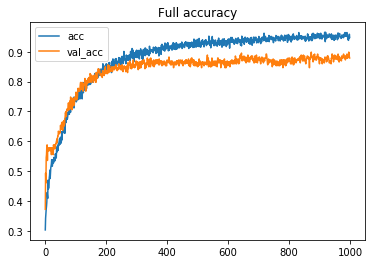

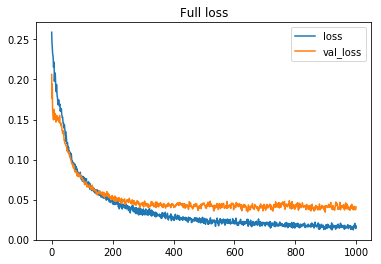

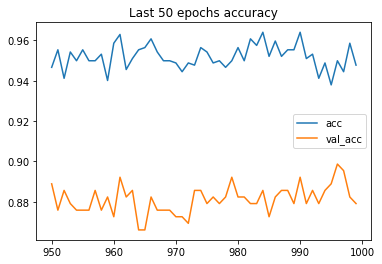

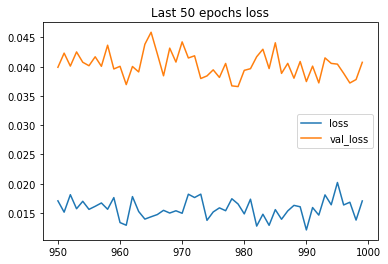

In [8]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [9]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [10]:
best_model.evaluate(test_data, test_labels)

306/306 [==============================] - 0s 202us/step


[0.02760991920841465, 0.9183006535947712]

In [11]:
best_model.predict(test_data[0:1])

array([[0.0000000e+00, 6.7135645e-28, 7.2271739e-15, 0.0000000e+00,
        1.0000000e+00]], dtype=float32)